## Link Dataset:
https://www.kaggle.com/datasets/prasadvpatil/mrl-dataset/versions/3

In [11]:
import kagglehub
import os
import pandas as pd
from sklearn.model_selection import GroupShuffleSplit, GroupKFold

DATASET_PATH = kagglehub.dataset_download("prasadvpatil/mrl-dataset/versions/3")
TRAIN_DIR = os.path.join(DATASET_PATH, "train")
print("Path to dataset files:", DATASET_PATH)

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import cv2
import numpy as np

BATCH_SIZE = 32
LEARNING_RATE = 5e-5
WEIGHT_DECAY = 1e-4
EPOCHS = 50
IMG_SIZE = 64
TEST_SPLIT = 0.15
N_FOLDS = 5

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)

Path to dataset files: C:\Users\GN\.cache\kagglehub\datasets\prasadvpatil\mrl-dataset\versions\3
Using device: cuda


In [12]:
class EyeDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img = Image.open(self.image_paths[idx]).convert("L")  
        label = self.labels[idx]

        if self.transform:
            img = self.transform(img)

        return img, label

In [13]:
classes = sorted(os.listdir(TRAIN_DIR)) 
all_image_paths = []
all_labels = []
all_subject_ids = []

for label_idx, label in enumerate(classes):
    class_dir = os.path.join(TRAIN_DIR, label)
    for img_file in os.listdir(class_dir):
        if img_file.lower().endswith((".png", ".jpg", ".jpeg")):
            full_path = os.path.join(class_dir, img_file)
            all_image_paths.append(full_path)
            all_labels.append(label_idx)
            
            filename = os.path.basename(img_file)
            subject_id = filename.split('_')[0] 
            all_subject_ids.append(subject_id)

df = pd.DataFrame({
    'path': all_image_paths,
    'label': all_labels,
    'subject_id': all_subject_ids
})

splitter_test = GroupShuffleSplit(test_size=TEST_SPLIT, n_splits=1, random_state=42)
trainval_idxs, test_idxs = next(splitter_test.split(df, groups=df['subject_id']))

trainval_df = df.iloc[trainval_idxs]
test_df = df.iloc[test_idxs]

test_paths = test_df['path'].tolist()
test_labels = test_df['label'].tolist()

print(f"Total Subjects: {df['subject_id'].nunique()}")
print(f"TrainVal Subjects: {trainval_df['subject_id'].nunique()}")
print(f"Test Subjects:     {test_df['subject_id'].nunique()}")
print(f"TrainVal images:   {len(trainval_df)}")
print(f"Test images:       {len(test_df)}")

Total Subjects: 19
TrainVal Subjects: 16
Test Subjects:     3
TrainVal images:   7275
Test images:       2725


## Data Splitting 

In [14]:
trainval_subjects = set(trainval_df['subject_id'])
test_subjects = set(test_df['subject_id'])

overlap = trainval_subjects.intersection(test_subjects)
print(f"Overlap between TrainVal and Test: {len(overlap)}")

Overlap between TrainVal and Test: 0


In [15]:
class AddGaussianNoise:
    def __init__(self, mean=0., std=0.05):
        self.mean = mean
        self.std = std
    
    def __call__(self, tensor):
        return tensor + torch.randn(tensor.size()) * self.std + self.mean

train_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.4, contrast=0.4),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 2.0)),
    transforms.ToTensor(),
    AddGaussianNoise(mean=0., std=0.05),
    transforms.RandomErasing(p=0.2, scale=(0.02, 0.15)),
    transforms.Normalize(mean=[0.5], std=[0.5]),
])

val_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5]),
])

In [16]:
test_dataset = EyeDataset(test_paths, test_labels, transform=val_transform)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [17]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Dropout2d(p=0.2),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout2d(p=0.3),
            nn.MaxPool2d(2),

            nn.Conv2d(64, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout2d(p=0.4),
            nn.MaxPool2d(2),

            nn.Flatten(),
            nn.Dropout(p=0.6),
            nn.Linear(128 * (IMG_SIZE // 8) * (IMG_SIZE // 8), 128),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(128, 2)
        )

    def forward(self, x):
        return self.net(x)

Starting 5-Fold Cross-Validation...

FOLD 1/5
Train subjects: 15, images: 5659
Val subjects:   1, images: 1616
Epoch 1/50 | Train Loss: 0.6585, Acc: 0.6066 | Val Loss: 0.7090, Acc: 0.3775
Epoch 5/50 | Train Loss: 0.4130, Acc: 0.8184 | Val Loss: 0.5066, Acc: 0.7598
Epoch 10/50 | Train Loss: 0.3396, Acc: 0.8609 | Val Loss: 0.4099, Acc: 0.8370
Early stopping at epoch 13


C:\Users\GN\AppData\Local\Temp\ipykernel_39444\695978343.py:104: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f"outputs/cnn_2/fold_{fold}_b

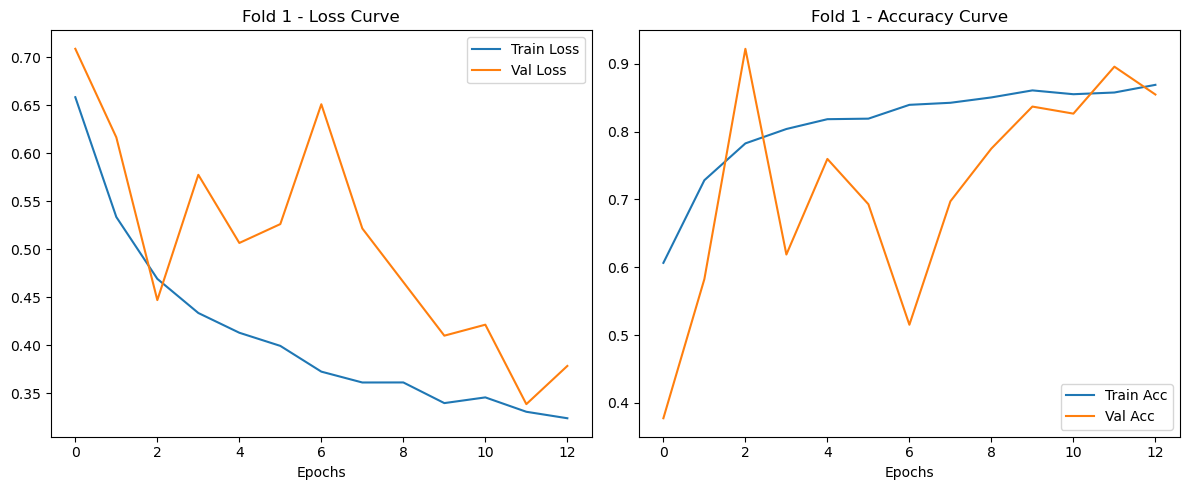

Fold 1 Best Val Accuracy: 0.9222

FOLD 2/5
Train subjects: 14, images: 5828
Val subjects:   2, images: 1447
Epoch 1/50 | Train Loss: 0.6103, Acc: 0.6875 | Val Loss: 0.8001, Acc: 0.0156
Epoch 5/50 | Train Loss: 0.4204, Acc: 0.8139 | Val Loss: 0.6498, Acc: 0.8064
Epoch 10/50 | Train Loss: 0.3559, Acc: 0.8499 | Val Loss: 0.8252, Acc: 0.6773
Early stopping at epoch 14


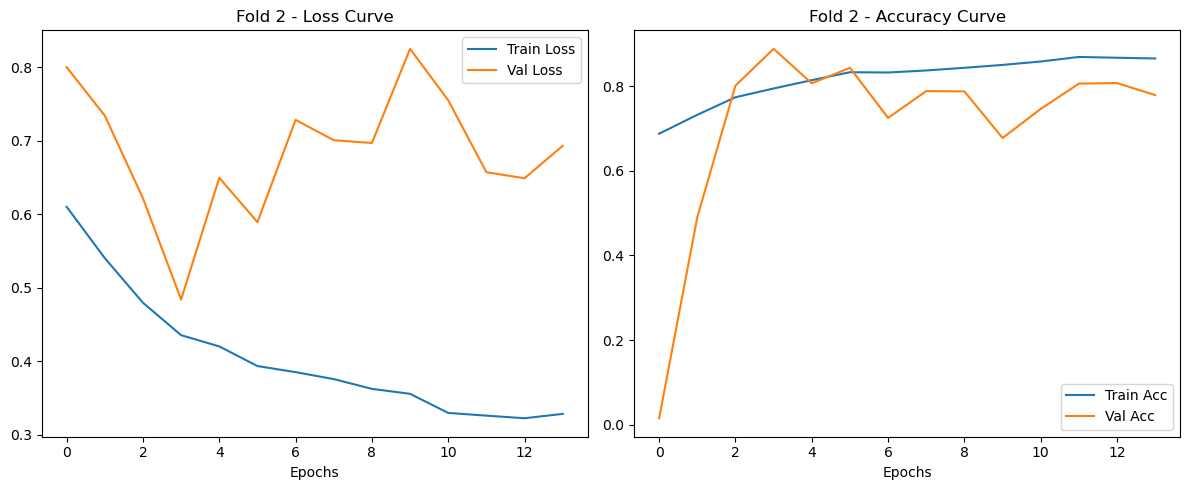

Fold 2 Best Val Accuracy: 0.8879

FOLD 3/5
Train subjects: 12, images: 5859
Val subjects:   4, images: 1416
Epoch 1/50 | Train Loss: 0.5689, Acc: 0.7055 | Val Loss: 0.7224, Acc: 0.5042
Epoch 5/50 | Train Loss: 0.3578, Acc: 0.8454 | Val Loss: 0.4631, Acc: 0.9229
Epoch 10/50 | Train Loss: 0.3141, Acc: 0.8625 | Val Loss: 0.3989, Acc: 0.9167
Epoch 15/50 | Train Loss: 0.2571, Acc: 0.8981 | Val Loss: 0.3376, Acc: 0.9264
Epoch 20/50 | Train Loss: 0.2208, Acc: 0.9119 | Val Loss: 0.3075, Acc: 0.9528
Epoch 25/50 | Train Loss: 0.1981, Acc: 0.9217 | Val Loss: 0.3616, Acc: 0.9493
Epoch 30/50 | Train Loss: 0.1686, Acc: 0.9361 | Val Loss: 0.3681, Acc: 0.9500
Epoch 35/50 | Train Loss: 0.1678, Acc: 0.9378 | Val Loss: 0.3569, Acc: 0.9563
Early stopping at epoch 39


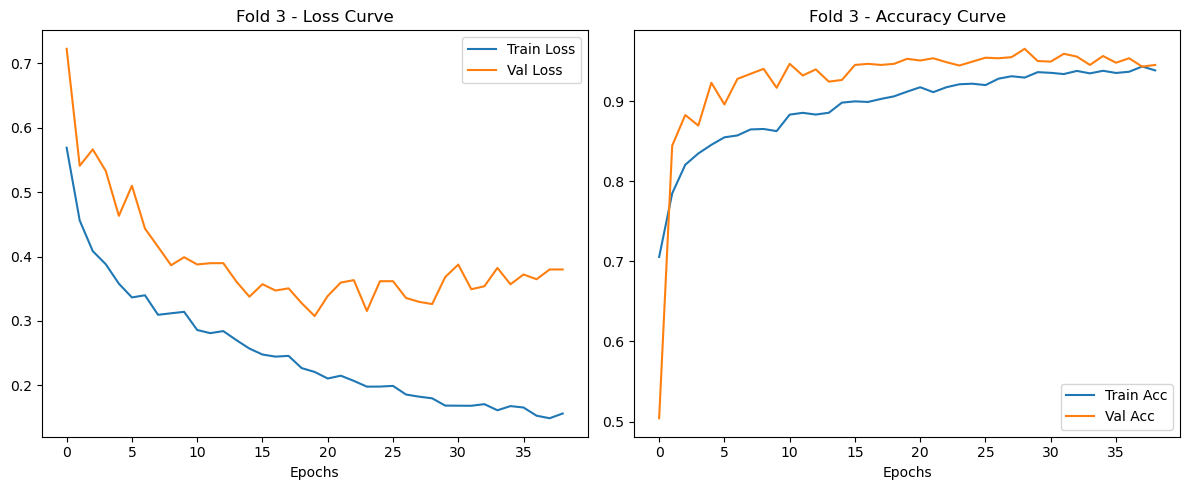

Fold 3 Best Val Accuracy: 0.9653

FOLD 4/5
Train subjects: 12, images: 5856
Val subjects:   4, images: 1419
Epoch 1/50 | Train Loss: 0.6024, Acc: 0.6670 | Val Loss: 0.7362, Acc: 0.3118
Epoch 5/50 | Train Loss: 0.3790, Acc: 0.8350 | Val Loss: 0.5028, Acc: 0.9077
Epoch 10/50 | Train Loss: 0.3244, Acc: 0.8700 | Val Loss: 0.3398, Acc: 0.9472
Epoch 15/50 | Train Loss: 0.2848, Acc: 0.8786 | Val Loss: 0.3019, Acc: 0.9521
Epoch 20/50 | Train Loss: 0.2626, Acc: 0.8970 | Val Loss: 0.2360, Acc: 0.9493
Epoch 25/50 | Train Loss: 0.2206, Acc: 0.9144 | Val Loss: 0.2238, Acc: 0.9576
Epoch 30/50 | Train Loss: 0.2070, Acc: 0.9197 | Val Loss: 0.1490, Acc: 0.9660
Epoch 35/50 | Train Loss: 0.1866, Acc: 0.9279 | Val Loss: 0.1489, Acc: 0.9576
Epoch 40/50 | Train Loss: 0.1666, Acc: 0.9401 | Val Loss: 0.1300, Acc: 0.9736
Epoch 45/50 | Train Loss: 0.1542, Acc: 0.9430 | Val Loss: 0.1306, Acc: 0.9757
Epoch 50/50 | Train Loss: 0.1411, Acc: 0.9460 | Val Loss: 0.1243, Acc: 0.9792


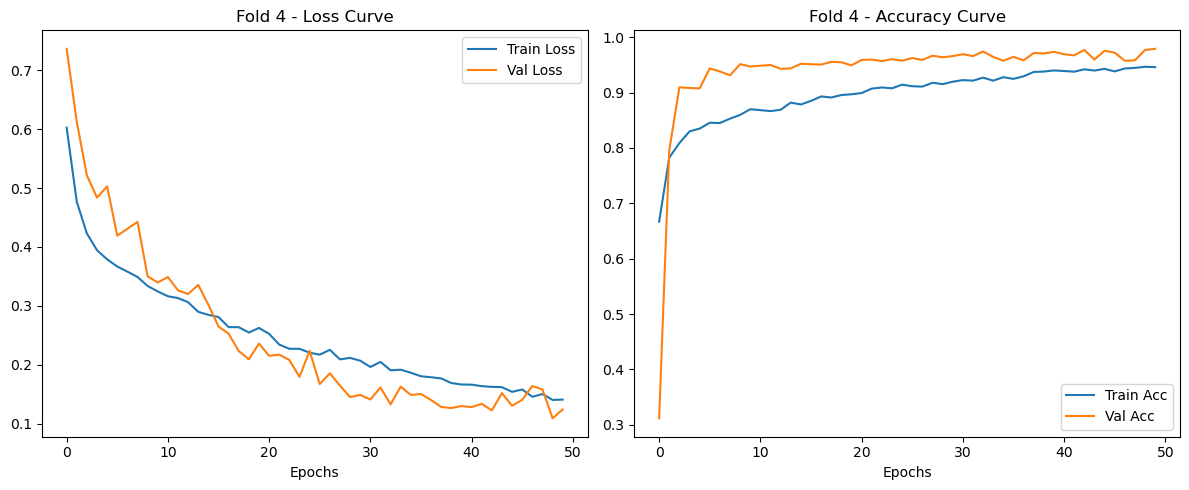

Fold 4 Best Val Accuracy: 0.9792

FOLD 5/5
Train subjects: 11, images: 5898
Val subjects:   5, images: 1377
Epoch 1/50 | Train Loss: 0.6152, Acc: 0.6608 | Val Loss: 0.6676, Acc: 0.6051
Epoch 5/50 | Train Loss: 0.3382, Acc: 0.8600 | Val Loss: 0.5984, Acc: 0.7287
Epoch 10/50 | Train Loss: 0.2611, Acc: 0.8998 | Val Loss: 0.6233, Acc: 0.6612
Epoch 15/50 | Train Loss: 0.2144, Acc: 0.9213 | Val Loss: 0.5301, Acc: 0.8132
Epoch 20/50 | Train Loss: 0.1952, Acc: 0.9247 | Val Loss: 0.4533, Acc: 0.8303
Epoch 25/50 | Train Loss: 0.1583, Acc: 0.9397 | Val Loss: 0.4230, Acc: 0.8224
Epoch 30/50 | Train Loss: 0.1502, Acc: 0.9448 | Val Loss: 0.3842, Acc: 0.8757
Epoch 35/50 | Train Loss: 0.1404, Acc: 0.9446 | Val Loss: 0.3898, Acc: 0.8359
Epoch 40/50 | Train Loss: 0.1315, Acc: 0.9520 | Val Loss: 0.3612, Acc: 0.8835
Epoch 45/50 | Train Loss: 0.1153, Acc: 0.9586 | Val Loss: 0.3801, Acc: 0.8743
Epoch 50/50 | Train Loss: 0.1062, Acc: 0.9606 | Val Loss: 0.3360, Acc: 0.8750


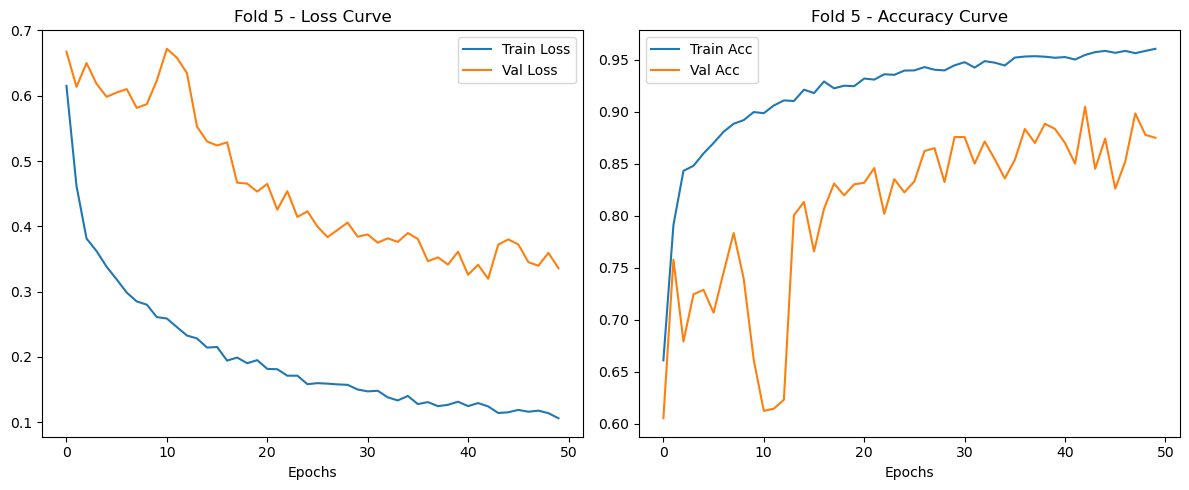

Fold 5 Best Val Accuracy: 0.9048


K-FOLD CROSS-VALIDATION SUMMARY
Fold 1: Best Val Acc = 0.9222
Fold 2: Best Val Acc = 0.8879
Fold 3: Best Val Acc = 0.9653
Fold 4: Best Val Acc = 0.9792
Fold 5: Best Val Acc = 0.9048

Mean Val Accuracy: 0.9319 ± 0.0350
Best Fold: 4 with Val Acc: 0.9792

Loading best model from Fold 4 for final test evaluation...


C:\Users\GN\AppData\Local\Temp\ipykernel_39444\695978343.py:157: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  final_model.load_state_dict(torch.load(f"outputs/cnn_2/fold_{b

<All keys matched successfully>

In [ ]:
import torch
import torch.optim as optim
import matplotlib.pyplot as plt

os.makedirs("outputs/cnn_2", exist_ok=True)

def accuracy(preds, labels):
    return (preds.argmax(dim=1) == labels).float().mean().item()

group_kfold = GroupKFold(n_splits=N_FOLDS)
fold_results = []
all_fold_histories = []

print(f"Starting {N_FOLDS}-Fold Cross-Validation...\n")

for fold, (train_idx, val_idx) in enumerate(group_kfold.split(trainval_df, groups=trainval_df['subject_id']), 1):
    print(f"{'='*60}")
    print(f"FOLD {fold}/{N_FOLDS}")
    print(f"{'='*60}")
    
    train_fold_df = trainval_df.iloc[train_idx]
    val_fold_df = trainval_df.iloc[val_idx]
    
    print(f"Train subjects: {train_fold_df['subject_id'].nunique()}, images: {len(train_fold_df)}")
    print(f"Val subjects:   {val_fold_df['subject_id'].nunique()}, images: {len(val_fold_df)}")
    
    train_dataset = EyeDataset(train_fold_df['path'].tolist(), train_fold_df['label'].tolist(), transform=train_transform)
    val_dataset = EyeDataset(val_fold_df['path'].tolist(), val_fold_df['label'].tolist(), transform=val_transform)
    
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
    
    model = CNN().to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)
    
    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []
    
    best_val_acc = 0.0
    early_stopping_patience = 10
    epochs_no_improve = 0
    
    for epoch in range(EPOCHS):
        model.train()
        total_loss, total_acc = 0, 0
        
        for imgs, lbls in train_loader:
            imgs, lbls = imgs.to(device), lbls.to(device)
            
            optimizer.zero_grad()
            outputs = model(imgs)
            loss = criterion(outputs, lbls)
            
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
            total_acc += accuracy(outputs, lbls)
        
        avg_train_loss = total_loss / len(train_loader)
        avg_train_acc = total_acc / len(train_loader)
        
        train_losses.append(avg_train_loss)
        train_accs.append(avg_train_acc)
        
        model.eval()
        val_loss_sum, val_acc_sum = 0, 0
        
        with torch.no_grad():
            for imgs, lbls in val_loader:
                imgs, lbls = imgs.to(device), lbls.to(device)
                outputs = model(imgs)
                loss = criterion(outputs, lbls)
                
                val_loss_sum += loss.item()
                val_acc_sum += accuracy(outputs, lbls)
        
        avg_val_loss = val_loss_sum / len(val_loader)
        avg_val_acc = val_acc_sum / len(val_loader)
        
        val_losses.append(avg_val_loss)
        val_accs.append(avg_val_acc)
        
        scheduler.step(avg_val_loss)
        
        if (epoch + 1) % 5 == 0 or epoch == 0:
            print(f"Epoch {epoch+1}/{EPOCHS} | Train Loss: {avg_train_loss:.4f}, Acc: {avg_train_acc:.4f} | Val Loss: {avg_val_loss:.4f}, Acc: {avg_val_acc:.4f}")
        
        if avg_val_acc > best_val_acc:
            best_val_acc = avg_val_acc
            torch.save(model.state_dict(), f"outputs/cnn_2/fold_{fold}_best_model.pth")
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
        
        if epochs_no_improve >= early_stopping_patience:
            print(f"Early stopping at epoch {epoch+1}")
            break
    
    model.load_state_dict(torch.load(f"outputs/cnn_2/fold_{fold}_best_model.pth"))
    
    fold_results.append({
        'fold': fold,
        'best_val_acc': best_val_acc,
        'final_train_acc': train_accs[-1],
        'final_val_acc': val_accs[-1]
    })
    
    all_fold_histories.append({
        'train_losses': train_losses,
        'val_losses': val_losses,
        'train_accs': train_accs,
        'val_accs': val_accs
    })
    
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label="Train Loss")
    plt.plot(val_losses, label="Val Loss")
    plt.title(f"Fold {fold} - Loss Curve")
    plt.xlabel("Epochs")
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(train_accs, label="Train Acc")
    plt.plot(val_accs, label="Val Acc")
    plt.title(f"Fold {fold} - Accuracy Curve")
    plt.xlabel("Epochs")
    plt.legend()
    
    plt.tight_layout()
    plt.savefig(f"outputs/cnn_2/fold_{fold}_training_curves.png", dpi=300, bbox_inches='tight')
    plt.show()
    
    print(f"Fold {fold} Best Val Accuracy: {best_val_acc:.4f}\n")

print(f"\n{'='*60}")
print("K-FOLD CROSS-VALIDATION SUMMARY")
print(f"{'='*60}")
for result in fold_results:
    print(f"Fold {result['fold']}: Best Val Acc = {result['best_val_acc']:.4f}")

mean_val_acc = np.mean([r['best_val_acc'] for r in fold_results])
std_val_acc = np.std([r['best_val_acc'] for r in fold_results])
print(f"\nMean Val Accuracy: {mean_val_acc:.4f} ± {std_val_acc:.4f}")

best_fold_idx = np.argmax([r['best_val_acc'] for r in fold_results])
best_fold = fold_results[best_fold_idx]['fold']
print(f"Best Fold: {best_fold} with Val Acc: {fold_results[best_fold_idx]['best_val_acc']:.4f}")


K-FOLD CROSS-VALIDATION SUMMARY

Detailed Results by Fold:
 fold  best_val_acc  final_train_acc  final_val_acc  final_train_loss  final_val_loss
    1      0.922181         0.869043       0.854779          0.323841        0.378367
    2      0.887908         0.865096       0.778533          0.328643        0.693217
    3      0.965278         0.938349       0.945139          0.156323        0.379963
    4      0.979167         0.946038       0.979167          0.141054        0.124289
    5      0.904830         0.960642       0.875000          0.106202        0.335993

STATISTICAL SUMMARY
Train Accuracy      : 0.9158 ± 0.0453 (min: 0.8651, max: 0.9606)
Val Accuracy        : 0.9319 ± 0.0391 (min: 0.8879, max: 0.9792)
Train Loss          : 0.2112 ± 0.1066 (min: 0.1062, max: 0.3286)
Val Loss            : 0.3824 ± 0.2033 (min: 0.1243, max: 0.6932)

Best Fold: 4 with Val Acc: 0.9792


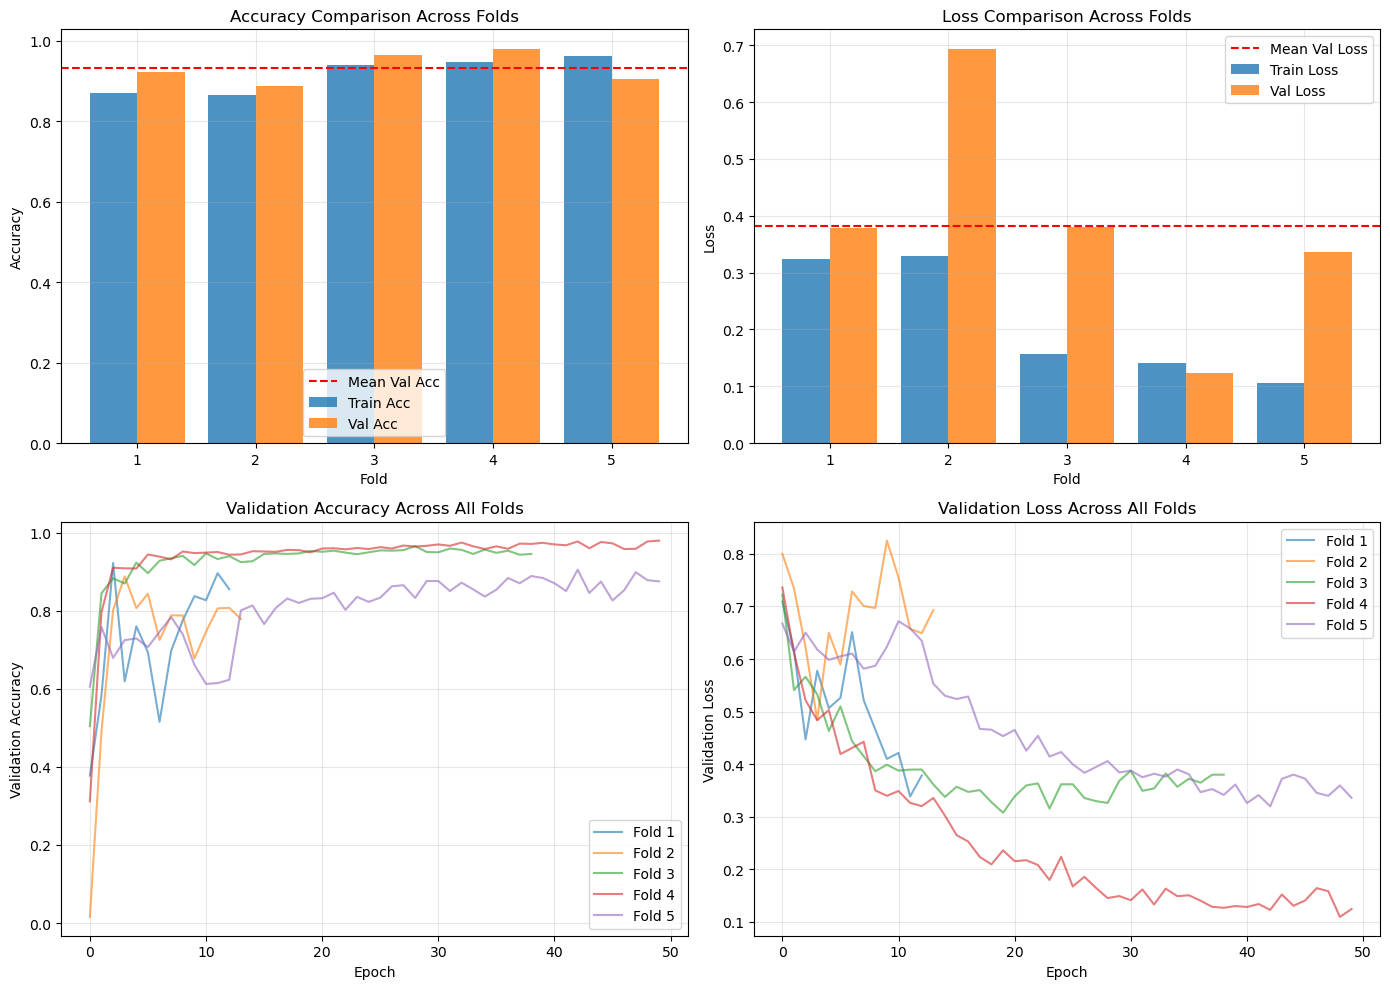


Loading best model from Fold 4 for final test evaluation...


C:\Users\GN\AppData\Local\Temp\ipykernel_39444\866227713.py:81: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  final_model.load_state_dict(torch.load(f"outputs/cnn_2/fold_{be

<All keys matched successfully>

In [19]:
print(f"\n{'='*60}")
print("K-FOLD CROSS-VALIDATION SUMMARY")
print(f"{'='*60}")

results_df = pd.DataFrame(fold_results)

for i, history in enumerate(all_fold_histories):
    results_df.loc[i, 'final_train_loss'] = history['train_losses'][-1]
    results_df.loc[i, 'final_val_loss'] = history['val_losses'][-1]

print("\nDetailed Results by Fold:")
print(results_df.to_string(index=False))

print(f"\n{'='*60}")
print("STATISTICAL SUMMARY")
print(f"{'='*60}")

metrics = {
    'Train Accuracy': results_df['final_train_acc'],
    'Val Accuracy': results_df['best_val_acc'],
    'Train Loss': results_df['final_train_loss'],
    'Val Loss': results_df['final_val_loss']
}

for metric_name, values in metrics.items():
    mean = values.mean()
    std = values.std()
    min_val = values.min()
    max_val = values.max()
    print(f"{metric_name:20s}: {mean:.4f} ± {std:.4f} (min: {min_val:.4f}, max: {max_val:.4f})")

print(f"\n{'='*60}")
print(f"Best Fold: {best_fold} with Val Acc: {fold_results[best_fold_idx]['best_val_acc']:.4f}")
print(f"{'='*60}")

results_df.to_csv("outputs/cnn_2/kfold_results_summary.csv", index=False)

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

axes[0, 0].bar(results_df['fold'] - 0.2, results_df['final_train_acc'], 0.4, label='Train Acc', alpha=0.8)
axes[0, 0].bar(results_df['fold'] + 0.2, results_df['best_val_acc'], 0.4, label='Val Acc', alpha=0.8)
axes[0, 0].axhline(y=results_df['best_val_acc'].mean(), color='r', linestyle='--', label='Mean Val Acc')
axes[0, 0].set_xlabel('Fold')
axes[0, 0].set_ylabel('Accuracy')
axes[0, 0].set_title('Accuracy Comparison Across Folds')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

axes[0, 1].bar(results_df['fold'] - 0.2, results_df['final_train_loss'], 0.4, label='Train Loss', alpha=0.8)
axes[0, 1].bar(results_df['fold'] + 0.2, results_df['final_val_loss'], 0.4, label='Val Loss', alpha=0.8)
axes[0, 1].axhline(y=results_df['final_val_loss'].mean(), color='r', linestyle='--', label='Mean Val Loss')
axes[0, 1].set_xlabel('Fold')
axes[0, 1].set_ylabel('Loss')
axes[0, 1].set_title('Loss Comparison Across Folds')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

for i, history in enumerate(all_fold_histories):
    axes[1, 0].plot(history['val_accs'], label=f'Fold {i+1}', alpha=0.6)
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Validation Accuracy')
axes[1, 0].set_title('Validation Accuracy Across All Folds')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

for i, history in enumerate(all_fold_histories):
    axes[1, 1].plot(history['val_losses'], label=f'Fold {i+1}', alpha=0.6)
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('Validation Loss')
axes[1, 1].set_title('Validation Loss Across All Folds')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig("outputs/cnn_2/kfold_summary_plots.png", dpi=300, bbox_inches='tight')
plt.show()

print(f"\nLoading best model from Fold {best_fold} for final test evaluation...")

final_model = CNN().to(device)
final_model.load_state_dict(torch.load(f"outputs/cnn_2/fold_{best_fold}_best_model.pth"))

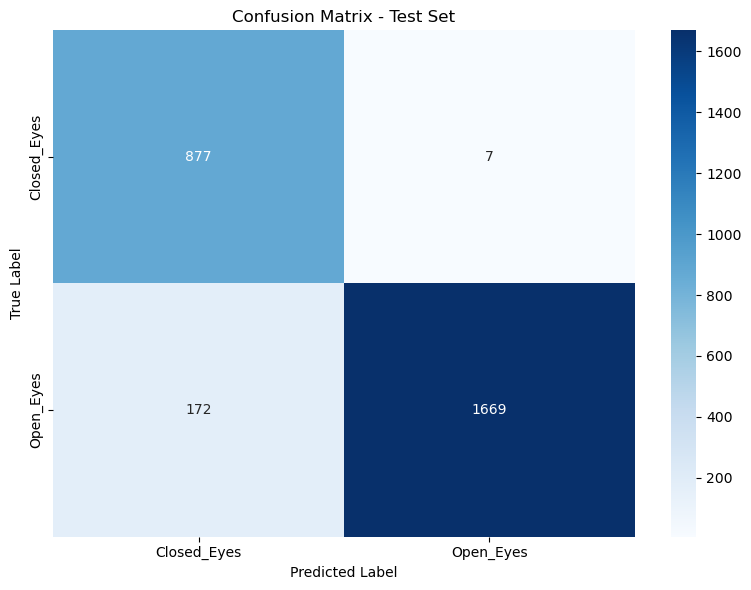

Classification Report (Test Set):
               precision    recall  f1-score   support

 Closed_Eyes       0.84      0.99      0.91       884
   Open_Eyes       1.00      0.91      0.95      1841

    accuracy                           0.93      2725
   macro avg       0.92      0.95      0.93      2725
weighted avg       0.94      0.93      0.94      2725


Final Test Accuracy: 0.9343


In [20]:
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import seaborn as sns

final_model.eval()
y_true = []
y_pred = []

with torch.no_grad():
    for imgs, lbls in test_loader:
        imgs, lbls = imgs.to(device), lbls.to(device)
        outputs = final_model(imgs)
        _, predicted = torch.max(outputs.data, 1)
        y_true.extend(lbls.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

y_true = np.array(y_true)
y_pred = np.array(y_pred)

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
plt.title("Confusion Matrix - Test Set")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.savefig("outputs/cnn_2/confusion_matrix_test.png", dpi=300, bbox_inches='tight')
plt.show()

report = classification_report(y_true, y_pred, target_names=classes)
print("Classification Report (Test Set):\n", report)

test_acc = (y_true == y_pred).mean()
print(f"\nFinal Test Accuracy: {test_acc:.4f}")

## Test Sample Predictions Visualization

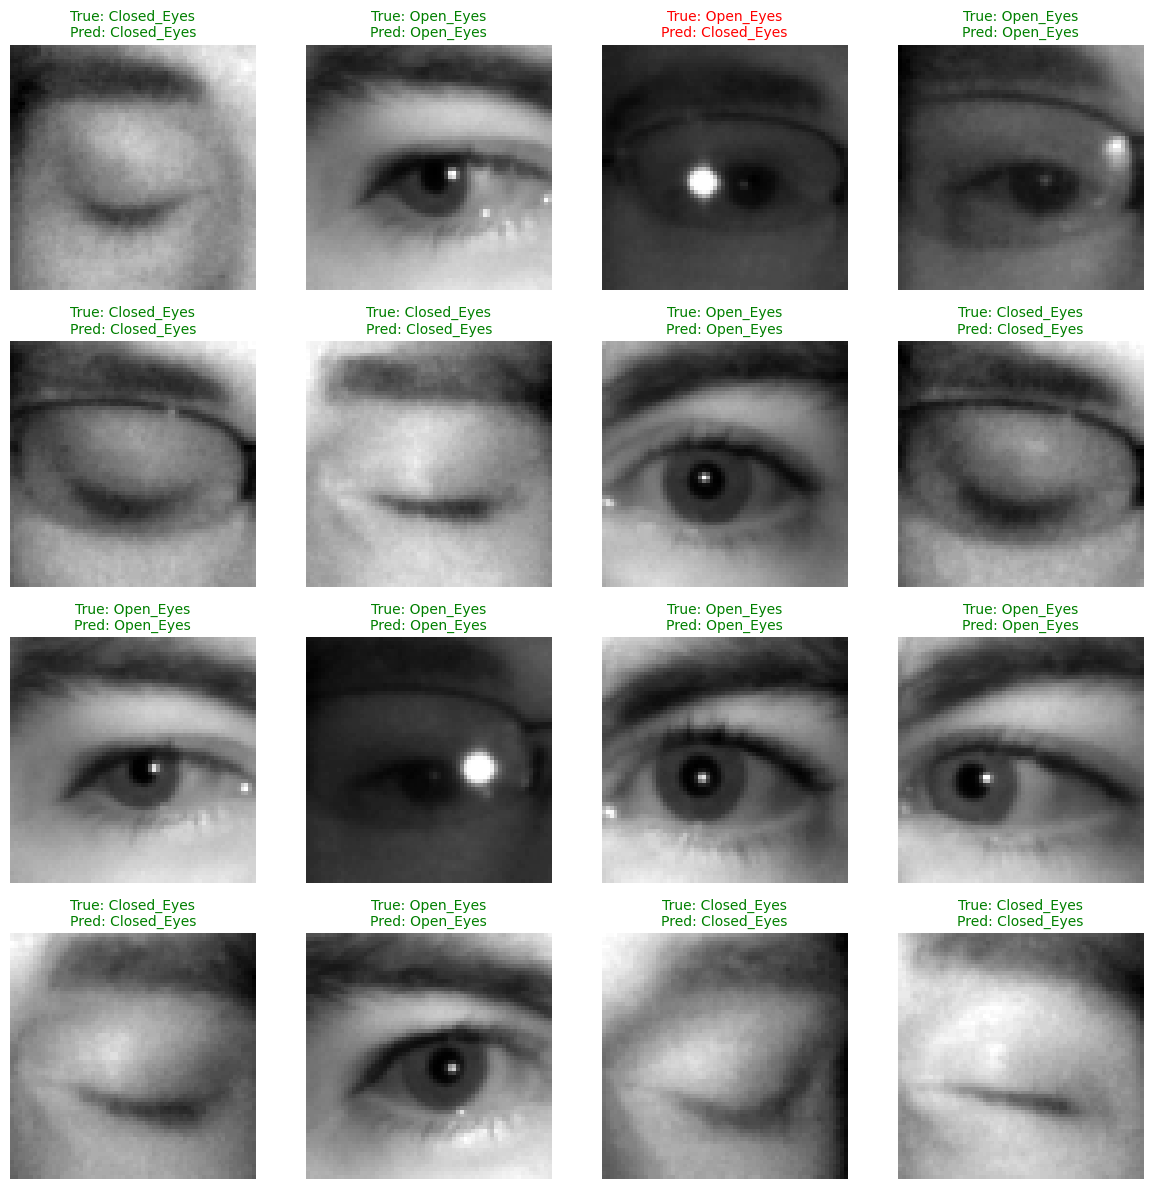

In [21]:
import random

num_samples = 16
sample_indices = random.sample(range(len(test_dataset)), num_samples)

fig, axes = plt.subplots(4, 4, figsize=(12, 12))
axes = axes.flatten()

final_model.eval()
with torch.no_grad():
    for i, idx in enumerate(sample_indices):
        img, true_label = test_dataset[idx]
        img_input = img.unsqueeze(0).to(device)
        
        output = final_model(img_input)
        pred_label = output.argmax(dim=1).item()
        
        img_display = img.squeeze().cpu().numpy()
        
        axes[i].imshow(img_display, cmap='gray')
        axes[i].axis('off')
        
        color = 'green' if pred_label == true_label else 'red'
        axes[i].set_title(f"True: {classes[true_label]}\nPred: {classes[pred_label]}", 
                         color=color, fontsize=10)

plt.tight_layout()
plt.savefig("outputs/cnn_2/test_predictions_sample.png", dpi=300, bbox_inches='tight')
plt.show()